## **Initialization and Parameter Setting**

The state of the five edges is represented by **component events**.  
Each edge can take a **binary state**:  
- `0`: Non-functional  
- `1`: Functional  

### **Edge Probabilities**
```python
probs = {
    'e1': {0: 0.01, 1: 0.99},
    'e2': {0: 0.01, 1: 0.99},
    'e3': {0: 0.05, 1: 0.95},
    'e4': {0: 0.05, 1: 0.95},
    'e5': {0: 0.10, 1: 0.90}
}

In [1]:
import itertools
import numpy as np
import networkx as nx
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb 
from IPython.display import Image, display

# Define the network
nodes = {'n1': (0, 0),
         'n2': (1, 1),
         'n3': (1, -1),
         'n4': (2, 0)}

edges = {'e1': ['n1', 'n2'],
         'e2': ['n1', 'n3'],
         'e3': ['n2', 'n3'],
         'e4': ['n2', 'n4'],
         'e5': ['n3', 'n4']}

probs = {'e1': 0.99, 'e2': 0.99, 'e3': 0.95, 'e4': 0.95, 'e5': 0.90}  # 엣지 신뢰도(survival probability)

## **Functions for Reliability Index and Redundancy Index**
$$
\beta_{ij} = -\Phi^{-1}(P(F_i \mid H_j))
$$

$$
\pi_{ij} = -\Phi^{-1}(P(F_{\text{sys}} \mid F_i, H_j))
$$

#### Flowchart: Monte Carlo Sampling and Redundancy Analysis

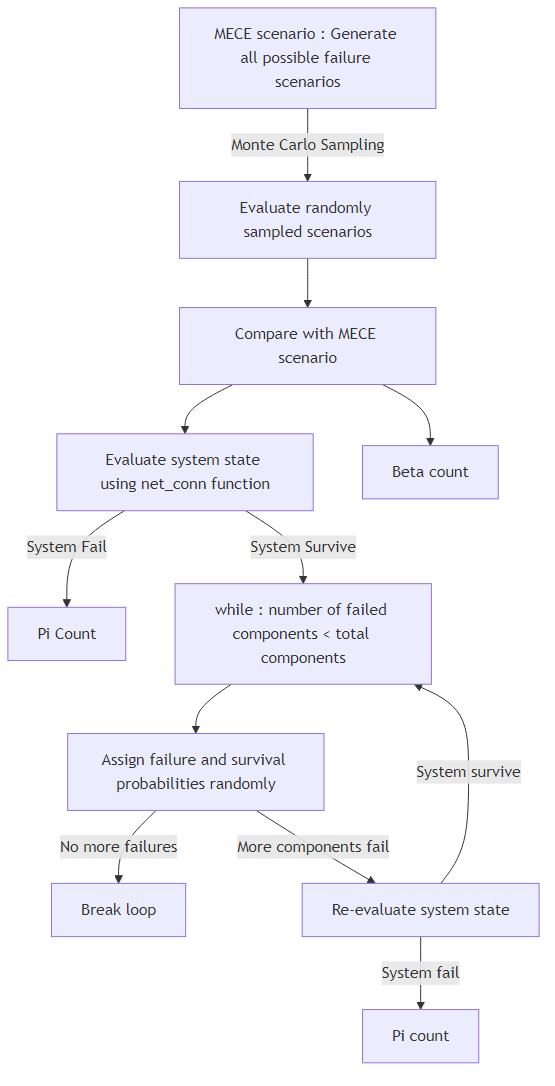

In [2]:
# PNG 파일 경로
png_file = "output.png"

# PNG 이미지 표시
display(Image(filename=png_file))

In [ ]:
def calculate_beta_pi(edges, probs, od_pair, MCS_N=1000000):
    num_edges = len(edges)
    num_mece = 2 ** num_edges - 1  
    mece = np.array([list(map(int, f"{i:0{num_edges}b}")) for i in range(1, 2 ** num_edges)])  

    # Count variables for each MECE scenario
    beta_count = np.zeros(num_mece)
    pi_count = np.zeros(num_mece)

    # Monte Carlo simulation
    for _ in range(MCS_N):
        comps_st = {e: np.random.choice([0, 1], p=[1 - probs[e], probs[e]]) for e in edges}  # 0: fail, 1: survive - state
        failure_mask = np.array([1 if comps_st[e] == 0 else 0 for e in edges])  # 1: fail, 0: survive - mask

        for scn_idx in range(num_mece):
            if np.array_equal(mece[scn_idx], failure_mask):
                beta_count[scn_idx] += 1

                f_val, sys_st, _ = net_conn(comps_st, od_pair, edges)
                if sys_st == 'f':  # If system is already failed
                    pi_count[scn_idx] += 1
                    break  # Skip load redistribution

                tmp_failure = np.sum(failure_mask)
                while tmp_failure < num_edges:
                    for e, state in comps_st.items():
                        if state == 1:  # if survive
                            comps_st[e] = np.random.choice([0, 1], p=[0.2, 0.8])

                    new_mask = np.array([1 if comps_st[e] == 0 else 0 for e in edges])
                    tmp_failure2 = np.sum(new_mask)

                    if tmp_failure2 > tmp_failure:  # New failures detected
                        f_val, sys_st, _ = net_conn(comps_st, od_pair, edges)
                        if sys_st == 'f':  # If system is in fail state
                            pi_count[scn_idx] += 1
                            break

                    if tmp_failure2 == tmp_failure:
                        break
                    tmp_failure = tmp_failure2

    beta_count[beta_count == 0] = 1e-5
    pi_count[pi_count == 0] = 1e-5
    redundancy = pi_count / beta_count
    redundancy = np.clip(redundancy, 1e-10, 1 - 1e-10)
    reliability = beta_count / MCS_N

    beta = -norm.ppf(reliability)
    pi = -norm.ppf(redundancy)

    beta[beta < -3] = -3
    pi[pi < -3] = -3

    # Print beta_count and pi_count for each MECE case
    print("\nMECE Case | Beta Count | Pi Count")
    print("---------------------------------")
    for idx, case in enumerate(mece):
        print(f"{case} | {beta_count[idx]:.5f} | {pi_count[idx]:.5f}")

    return beta, pi, mece


## **Network Connectivity Evaluation Function**

### **System Event**
The system state is evaluated by the network connectivity between a designated origin-destination (OD) pair. 

- **Survival**: The system state is considered *survived* if the OD pair is connected.  
- **Failure**: The system state is considered *failed* otherwise.

In [ ]:
def net_conn(comps_st, od_pair, edges):
    G = nx.Graph()
    for k, state in comps_st.items():
        if state == 1:  # if survive
            G.add_edge(edges[k][0], edges[k][1], capacity=1)  # capacity 직접 설정

    # OD 쌍 목적지에 새로운 노드 추가
    G.add_edge(od_pair[1], 'new_d', capacity=1)

    try:
        f_val, f_dict = nx.maximum_flow(G, od_pair[0], 'new_d', capacity='capacity', flow_func=nx.algorithms.flow.shortest_augmenting_path)

        if f_val > 0:
            sys_st = 's'
            return f_val, sys_st, {k: state for k, state in comps_st.items() if state == 1}
        else:
            return f_val, 'f', None
    except Exception as e:
        return 0, 'f', None

## **Results**

### **Questions**
1. 파이 값의 변화 양상이 크게 나타나지 않음
   이유 
   : 이 예제는 link set의 components failure scenario별 case가 다양하지 않다
   : components 들의 survival probability가 전반적으로 너무 크다(계산 과정에서 무시되는 case 발생)
2. Load redistribution 할 때 나머지 부재의 fail or survive를 random하게 부여해도 될 지 (0.2, 0.8로 임의 작성)  
   다른 부재들이 무너짐에 따라 해당 부재에 load가 몰리는 것에 대한 고려는 필요 없을까
3. 계산 시간 30분 내외


MECE Case | Beta Count | Pi Count
---------------------------------
[0 0 0 0 1] | 885166.00000 | 353817.00000
[0 0 0 1 0] | 419216.00000 | 167511.00000
[0 0 0 1 1] | 46487.00000 | 46487.00000
[0 0 1 0 0] | 417811.00000 | 131306.00000
[0 0 1 0 1] | 46134.00000 | 18716.00000
[0 0 1 1 0] | 22144.00000 | 9026.00000
[0 0 1 1 1] | 2388.00000 | 2388.00000
[0 1 0 0 0] | 80440.00000 | 32216.00000
[0 1 0 0 1] | 8949.00000 | 3619.00000
[0 1 0 1 0] | 4262.00000 | 2100.00000
[0 1 0 1 1] | 465.00000 | 465.00000
[0 1 1 0 0] | 4390.00000 | 1849.00000
[0 1 1 0 1] | 467.00000 | 169.00000
[0 1 1 1 0] | 238.00000 | 238.00000
[0 1 1 1 1] | 33.00000 | 33.00000
[1 0 0 0 0] | 80420.00000 | 32220.00000
[1 0 0 0 1] | 8806.00000 | 4365.00000
[1 0 0 1 0] | 4274.00000 | 1766.00000
[1 0 0 1 1] | 468.00000 | 468.00000
[1 0 1 0 0] | 4179.00000 | 1735.00000
[1 0 1 0 1] | 505.00000 | 505.00000
[1 0 1 1 0] | 223.00000 | 77.00000
[1 0 1 1 1] | 24.00000 | 24.00000
[1 1 0 0 0] | 838.00000 | 838.00000
[1 1 0 0 1] | 74.0000

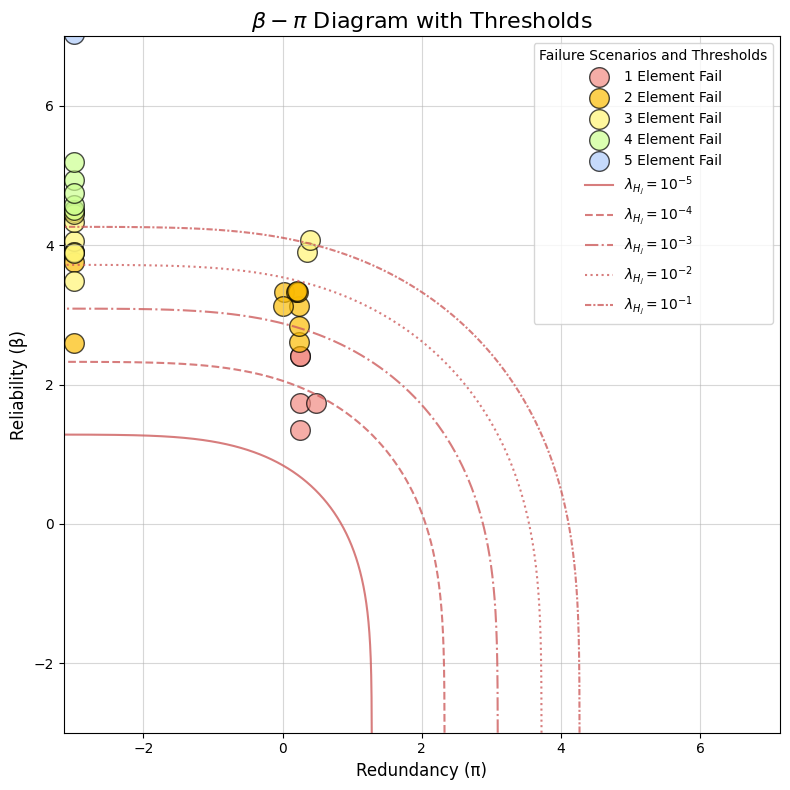

In [ ]:
# Main execution
beta_values = calculate_reliability(edges, probs)
beta, pi, mece = calculate_beta_pi(edges, probs, od_pair=('n1', 'n4'), MCS_N=10000000)

# Results output
print("Scenario | MECE Subset | Beta | Pi")
print("----------------------------------------------------")
for scn_idx in range(len(mece)):
    print(f"Scenario {scn_idx + 1}: {mece[scn_idx]}  -->  Beta: {beta[scn_idx]:.6f} | Pi: {pi[scn_idx]:.6f}")

# Count the number of failed elements for each MECE subset
failed_elements = np.sum(mece, axis=1)  # 실패한 부재 수 계산

# Define distinct colors for each number of failed elements
unique_fail_counts = np.unique(failed_elements)  # 고유한 실패 부재 개수
dominant_colors_hex = ['#f28b82', '#fbbc04', '#fff475', '#ccff90', '#aecbfa', '#d7aefb']
colors = [to_rgb(color) for color in dominant_colors_hex]

# Visualization
plt.figure(figsize=(8, 8))  # 전체 플롯 크기 설정

# 1. Scatter plot for β-π Diagram
for count, color in zip(unique_fail_counts, colors):
    indices = failed_elements == count  # 현재 실패 부재 개수와 일치하는 시나리오
    plt.scatter(pi[indices], beta[indices], color=color, s=200,  # 점의 크기 조정 (s=100)
                label=f"{count} Element Fail", edgecolors='k', alpha=0.7)

# 2. Plot Threshold Lines for Different prob_target Values
prob_targets = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
reverse_labels = [r'$\lambda_{H_j} = 10^{-5}$', r'$\lambda_{H_j} = 10^{-4}$', 
                  r'$\lambda_{H_j} = 10^{-3}$', r'$\lambda_{H_j} = 10^{-2}$', r'$\lambda_{H_j} = 10^{-1}$']
line_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]  # 다양한 선 스타일 설정

for prob_target, line_style, label in zip(prob_targets, line_styles, reverse_labels):
    beta_threshold = np.arange(-3, 8, 1e-4)  # β threshold range
    pi_threshold = -norm.ppf(prob_target / norm.cdf(-beta_threshold))  # π values for given threshold
    plt.plot(pi_threshold, beta_threshold, 'indianred', linestyle=line_style, 
             label=label, alpha=0.8)  # 포맷 변경

# Customize the plot
plt.title(r'$\beta - \pi$ Diagram with Thresholds', fontsize=16)
plt.xlabel('Redundancy (π)', fontsize=12)
plt.ylabel('Reliability (β)', fontsize=12)
plt.axis('equal')
plt.xlim([-3, 7])
plt.ylim([-3, 7])
plt.grid(alpha=0.5)
plt.legend(title="Failure Scenarios and Thresholds", fontsize=10, loc="best")
plt.tight_layout()
plt.show()